# PyTorch workflow

The implementation and learning of PyTorch workflow

Follow freeCodeCamp.org, what will be covered: 
1. : "data (prepare data and load),
2. : "build a model",
3. : "train the model using prepared data, 
4. : "saving model checkpoint and load it up", 
5. : "combine what we learn together"

In [1]:
import torch
print(torch.cuda.is_available())

from torch import nn 
import matplotlib.pyplot as plt 

print(torch.__version__)

True
2.5.1+cu124


##  1. Data (prepare data and loading data)

This will consist of: 
* Excel spreadsheet
* Image
* Video - Images
* Audio
* Text for LLM

Machine can not read our data, it can only read 0 and 1 - numerical version of data, so we have to: 
1. Convert data into numerical version 
2. Build a model to learn some what of a patterns from those datas

Like any old school lession the first form of "learnable" thing come in with linear regression with 
`Y = aX + b`, we'll use this formualla to make a straight line base on our data. 

In [2]:
# first create some data
import torch
weight = 0.3
bias = 0.7
X = torch.arange(start = 0, end = 1, step = 0.02).unsqueeze(dim = 1) # add another dimension 
Y = weight * X + bias

print(X[:10])
print(Y[:10])

print(len(X), len(Y))

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
tensor([[0.7000],
        [0.7060],
        [0.7120],
        [0.7180],
        [0.7240],
        [0.7300],
        [0.7360],
        [0.7420],
        [0.7480],
        [0.7540]])
50 50


### Splitting the data into train and test set (validate if we can). 
* Training set -> the model learns from this data - ~60-80%
* Validation set -> used to tune the model
* Test -> the model will get evaluated on this dataset to see what it learn and how well it perform 

In [3]:
# create train/test split 

train_split = int(0.8 * len(X))
print(train_split)

X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

print(len(X_train))

40
40


In [4]:
def plot_predictions(train_data = X_train, 
					 train_labels = Y_train, 
					 test_data = X_test, 
					 test_labels = Y_test, 
					 predictions=None):
	plt.figure(figsize=(10,7))

	# Plot the training data 
	plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

	# Plot test data 
	plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

	if predictions is not None: 
		plt.scatter(test_data, predictions, c="r", s=4, label="Prediction")

	plt.legend(prop={"size": 14})

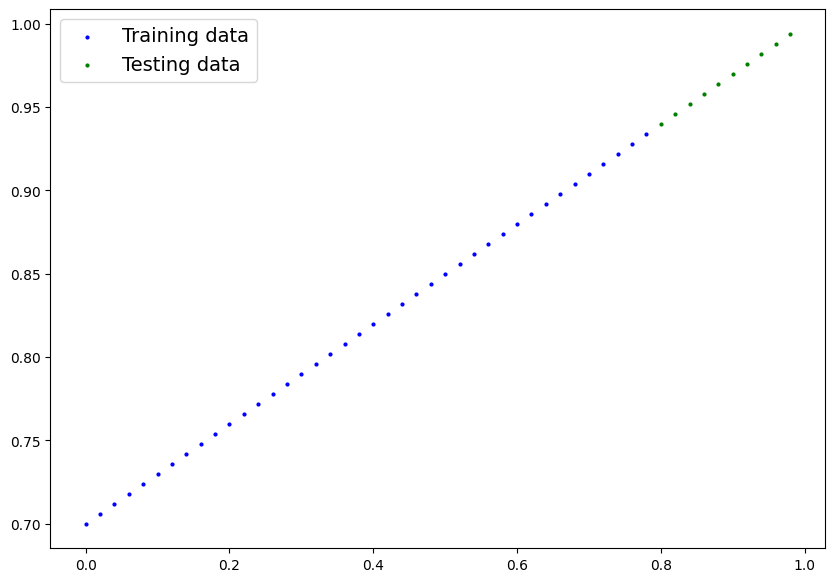

In [5]:
plot_predictions()

## 2. Building our very first model using PyTorch

Some note is that sine I've already familiar with gradient descend, it should not be noted here. The model basically: 
* Start with random values of weights and bias 
* Take in the training data and see how wrong it is -> adjust the random value 
* The adjustment happend thanks for using gradient descent and back propagation

### To build a model in PyTorch, there some essential thing to remember: 
* torch.nn - the foundation to build the computational graphs (or so can say a model)
* torch.nn.Paramerter - P is captialize - don't miss it :v, this one decide what params should model try (forward) and learn. As in the freecodecamp.org code guy said: "often a PyTorch layer from torch.nn will set these for us"
* torch.nn.Module - The base class for all neural network modules, if we subclass (inherit) like below you muse overwrite the forward method
* torch.optim - optim = optimizer, they will handle the gradient descent
* foward() - every model use this method to try (compute) from the input and produce the output

In [6]:
import torch
from torch import nn
# Create a linear regression model with PyTorch
class LinearRegression(nn.Module): # <- almost everything in pytorch inherit from nn.module
    # In PyTorch a module can contain another module, this feature allow us to build compliated model. 
    def __init__(self):
        # Use the default constructor from the nn.module base class
        super().__init__()
        self.weight = nn.Parameter(torch.rand(1, 
                                              requires_grad = True, # <- allow differentiation for gradient descent
                                              dtype = torch.float))
        
        self.bias = nn.Parameter(torch.rand(1, 
                                            requires_grad= True, 
                                            dtype= torch.float))
        
    # define a "forward" method - which is a mothod to put the input in and compute through the model
    def forward(self, x: torch.tensor) -> torch.tensor:
        # as the formualla for a linear function is ax + b = y
        return self.weight * x + self.bias

### Checking our PyTorch model 
Now we've created a model, let's see what's inside the model by using `.parameters()`.

In [7]:
# Create a random seed 
torch.manual_seed(42)

# create an instance for linearregression model 
model = LinearRegression()

# check out the model parameters
list(model.parameters())


[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

### Making prediction using `torch.inference_mode()`

* so why the inference mode ? 
* You can try run this without infernce_mode() context, but it will add the backward gradient function
* This help pytorch tracking data when you run training, but for inference, you won't need to do it 
* basically, it help your code faster

In [8]:
# Listed named parameters 
model.state_dict()

with torch.inference_mode():
    y_preds = model(X_test)

# no grad work too, but inference mode is prefer since it optimze better for the inerence process
with torch.no_grad():
    y_preds = model(X_test)

y_preds


tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

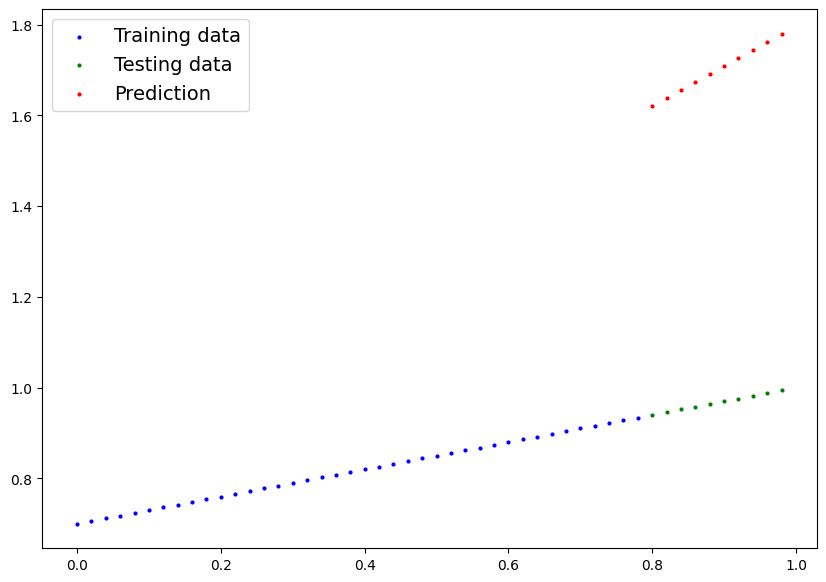

In [9]:
plot_predictions(predictions=y_preds)

## 3. Train model 
Simple way to explain what the training process is to: \\
run the model -> see how wrong it is -> adjust the parameters -> repeat again ... 

* To determine how wrong or how far is the prediction compare to the actual result, we use lost function 
* **Lost function:** is a function to determine how far our prediction compare to the ground truth. 
* It some time refer as **cost function** or **criterion**, but from my exp, the **cost funciton** term is used for lost functino **over a batch or a whole dataset** 
* **Optimizer** Takes into account how lost we are and adjust the parameters

For PyTorch, we mainly focusing on: 
* A loop for training 
* A loop for testing

### Setting up lost function and optimzation method for optimizer

In [10]:
# Setup a loss function 
loss_fn = nn.L1Loss()

# Setup an optimizer 
optimizer = torch.optim.SGD(params= model.parameters(),
                            lr= 0.01) # learning rate, higher the learning rate, the more aggressive the model adjust it weight

### Building a training loop (and testing loop) in PyTorch
The step by step when we training basically are:

0. Loop through the data
1. Consume it and forward it to get the predction result 
2. Calculate loss - how much the result is far a way from the ground truth 
3. Optimizer zero grad 
4. Loss backward - back propagation using chain rule to calcualte the gradien to adjust the loss backward in the NN 
5. Optimizer step - use the optimizer to adjust the model's parameters - improve the loss on the next run. (**gradient descent**)


In [14]:
model.parameters()

epochs = 180

epoch_count = []
loss_value = []
test_loss_value = []

# step 0 
for epoch in range(epochs):
    # Set the model to training mode 
    model.train() # Set all the params in the model require gradient to requires_gradient = True

    # step 1 forward the data
    y_preds = model(X_train)

    # step 2 calculate the lost
    loss = loss_fn(y_preds, Y_train)
    # step 3 optimize zero grad 
    optimizer.zero_grad()

    # step 4 back propogation
    loss.backward()

    # step 5 the optimizer (perform gradient descent)
    optimizer.step()

    ### Testing 
    # We basically turn off all the training relevant tracking stuff to 
    # run inference and check how well have the model perform 
    model.eval() # turns off gradient tracking
    with torch.inference_mode():
        # do the forward part 
        test_pred = model(X_test)

        # calculate the lost
        test_lost = loss_fn(test_pred, Y_test)
        test_loss_value.append(test_lost)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_lost}")
        print(model.state_dict())
    
    epoch_count.append(epoch)
    loss_value.append(loss)
    # Print out model state dict 


Epoch: 0 | Loss: 0.03442173823714256 | Test loss: 0.0799664855003357
OrderedDict([('weight', tensor([0.4696])), ('bias', tensor([0.6290]))])
Epoch: 10 | Loss: 0.030991386622190475 | Test loss: 0.07169410586357117
OrderedDict([('weight', tensor([0.4525])), ('bias', tensor([0.6360]))])
Epoch: 20 | Loss: 0.027552569285035133 | Test loss: 0.06342174112796783
OrderedDict([('weight', tensor([0.4353])), ('bias', tensor([0.6430]))])
Epoch: 30 | Loss: 0.024119755253195763 | Test loss: 0.055836208164691925
OrderedDict([('weight', tensor([0.4183])), ('bias', tensor([0.6505]))])
Epoch: 40 | Loss: 0.020687740296125412 | Test loss: 0.047563862055540085
OrderedDict([('weight', tensor([0.4012])), ('bias', tensor([0.6575]))])
Epoch: 50 | Loss: 0.01724892482161522 | Test loss: 0.03929150104522705
OrderedDict([('weight', tensor([0.3840])), ('bias', tensor([0.6645]))])
Epoch: 60 | Loss: 0.013817772269248962 | Test loss: 0.03170599415898323
OrderedDict([('weight', tensor([0.3671])), ('bias', tensor([0.6720

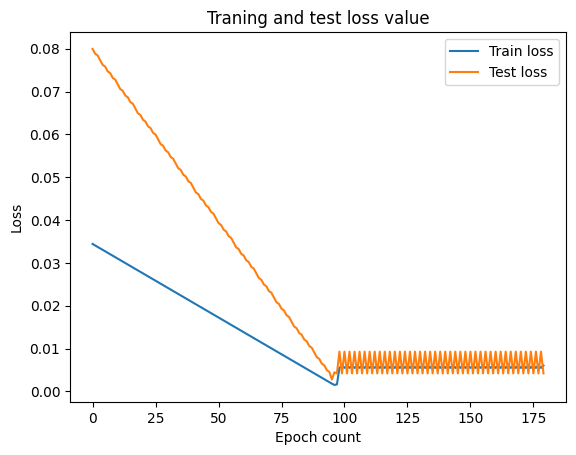

In [15]:
# plot up the loss to track for model
import numpy as np  
plt.plot(epoch_count, np.array([loss.detach().numpy() for loss in loss_value]), label="Train loss")
plt.plot(epoch_count, np.array([loss.detach().numpy() for loss in test_loss_value]), label="Test loss")
plt.title("Traning and test loss value")
plt.ylabel("Loss")
plt.xlabel("Epoch count")
plt.legend()
plt.show()

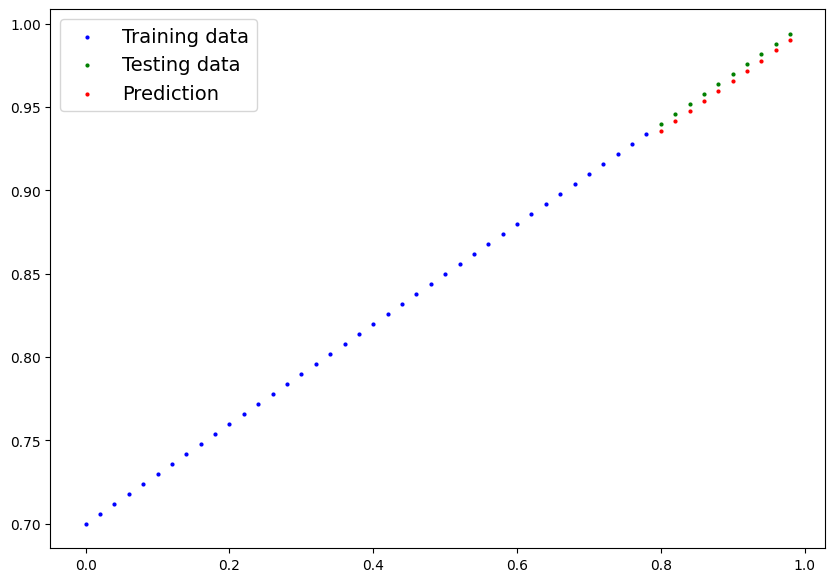

In [16]:
with torch.inference_mode(): 
    new_predicts = model(X_test)
    plot_predictions(predictions=new_predicts)
    

### Important notes here:
* What loss function and optimizer should we shoose ? 
* For a regression problem a loss function like `nn.L1Loss()` and optmizer like `torch.optim.SGD()` is used.\
But for classification the output should be squeeze into the range of 0 and 1, loss functino would be `nn.BCEloss()`, binary cross entropy loss. 

## 4. Saving model in PyTorch

There are 3 main methods for saving/loading models in PyTorch: 
1. `torch.save()` - save PyTorch object in Python Pickle format (binary format)
2. `torch.load()` - load PyTorch saved model (desrialized)
3. `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary

In [54]:
from pathlib import Path

# Saving PyTorch model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents= True, exist_ok=True)

MODEL_NAME = "01_Pytorch_Regression_model.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME



In [ ]:
# Save a full model will save the full subclass object inherit form the nn.module
torch.save(model,MODEL_SAVE_PATH)

# Load the full model up, no need to init the model and load the state dict into it
full_linear_regression_model = torch.load(f=MODEL_SAVE_PATH)
full_linear_regression_model.eval()
with torch.inference_mode():
    full_preds = full_linear_regression_model(X_test)

    plot_predictions(predictions=full_preds)

In [ ]:

# Recommend using save state dict only for a more lighter store
torch.save(model.state_dict(), MODEL_SAVE_PATH)

# Load the model up need reconstruct of the model to pass the state dict in
linear_regression_model = LinearRegression()
linear_regression_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

In [ ]:
print(linear_regression_model.state_dict())

linear_regression_model.eval()
with torch.inference_mode():
    preds = linear_regression_model(X_test)
    another_preds = model(X_test)
    plot_predictions(predictions=another_preds)

print(preds == another_preds) 

## 5. Put all of above together in one place

In [226]:
import torch
from matplotlib import pyplot
import numpy as np

if torch.cuda.is_available(): 
    device = "cuda"
else: device = "cpu"

print(f"Currently using device: {device}")

# Create some data set. 

weight = 0.7 
bias = 0.3 

X = torch.arange(start=0, end=10, step=0.2)
X = X.unsqueeze(dim=1)

Y = X * weight + bias

train_split = 0.8
train_len = int(len(X) * train_split)
X_train = X[:train_len]
Y_train = Y[:train_len]

X_test = X[train_len:]
Y_test = Y[train_len:]
print(X_test)

class TestingModel(nn.Module):
    def __init__(self):
        super().__init__()

        
        # the parameters will be a tensor 
        self.weight = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))

    
    def forward(self, input: torch.tensor) -> torch.tensor:
        return self.weight * input + self.bias
    
# Adding a plot function 
def plot_predictions(train_data = X_train, 
					 train_labels = Y_train,
					 test_data = X_test,
					 test_labels = Y_test, 
					 predictions=None):
	plt.figure(figsize=(10,7))
	
	plt.scatter(train_data, train_labels, c="b", s=5, label="Trainging data")
	
	plt.scatter(test_data, test_labels, c="g", s=5, label="Testing data")
	
	if predictions is not None: 
		plt.scatter(test_data, predictions, c="r", s=5, label="Predction")

	plt.legend(prop={"size": 14})
     
	 

Currently using device: cuda
tensor([[8.0000],
        [8.2000],
        [8.4000],
        [8.6000],
        [8.8000],
        [9.0000],
        [9.2000],
        [9.4000],
        [9.6000],
        [9.8000]])


In [229]:
torch.manual_seed(42)
model = TestingModel()
# The initial value of the model 
model.eval()
with torch.inference_mode():
	preds = model(X_test)
	print(preds)
	# plot_predictions(predictions=preds)


tensor([[7.9732],
        [8.1496],
        [8.3261],
        [8.5025],
        [8.6790],
        [8.8554],
        [9.0319],
        [9.2083],
        [9.3848],
        [9.5612]])


In [230]:
# Train the model
optimizer = torch.optim.SGD(lr=0.001, params=model.parameters())
loss_fn = nn.L1Loss()

epoch = 1080 
for i in range(epoch):
	# forward the data through model 
    preds = model(X_train)
    
	# figure out how far is the prediction compare to ground truth 
    loss = loss_fn(preds, Y_train)
    
	# optional, you can zero grad here to not accumulate gradient 
    optimizer.zero_grad()
    
	# now perform back propagation, to see how each node need to adjust 
    # the differentiate result is calculate using 
    loss.backward()
    
	# perform gradient decent using the loss 
    optimizer.step()
    
	# Evaluate the model after each epoch 
    model.eval() # disable all the gradient tracking 
    with torch.inference_mode(): 
        test_preds = model(X_test)
        test_loss = loss_fn(test_preds, Y_test)

    if i % 20 == 0: 
        print(f"Epoch: {i}, train lost: {loss}, prediction_loss: {test_loss}")
    
    

Epoch: 0, train lost: 1.3258540630340576, prediction_loss: 2.201490879058838
Epoch: 20, train lost: 1.001655101776123, prediction_loss: 1.4872922897338867
Epoch: 40, train lost: 0.6774559020996094, prediction_loss: 0.7730938196182251
Epoch: 60, train lost: 0.35325688123703003, prediction_loss: 0.05889582633972168
Epoch: 80, train lost: 0.22868940234184265, prediction_loss: 0.2842489182949066
Epoch: 100, train lost: 0.2239515334367752, prediction_loss: 0.31418976187705994
Epoch: 120, train lost: 0.22050423920154572, prediction_loss: 0.30845779180526733
Epoch: 140, train lost: 0.21706072986125946, prediction_loss: 0.30526742339134216
Epoch: 160, train lost: 0.21362332999706268, prediction_loss: 0.2995354235172272
Epoch: 180, train lost: 0.21017611026763916, prediction_loss: 0.2938033640384674
Epoch: 200, train lost: 0.20673954486846924, prediction_loss: 0.2906130850315094
Epoch: 220, train lost: 0.20329530537128448, prediction_loss: 0.2848811149597168
Epoch: 240, train lost: 0.1998480260

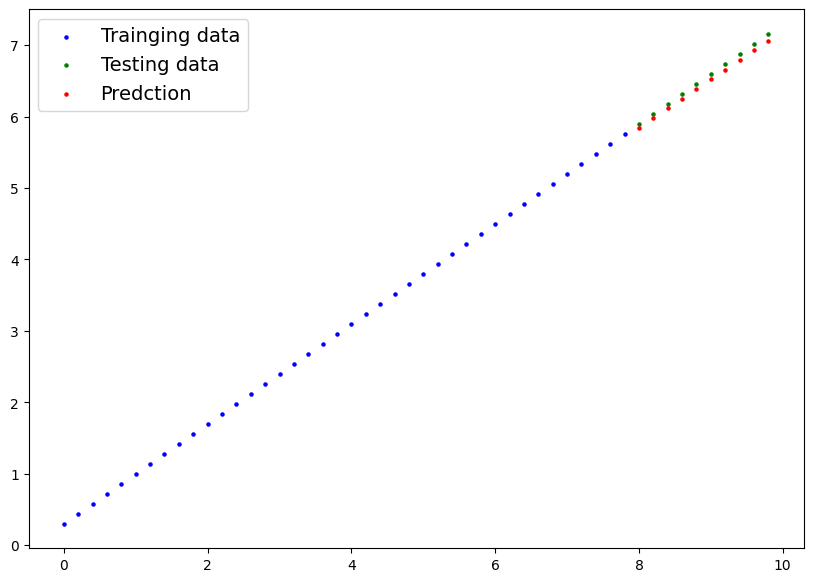

In [231]:
model.eval()
with torch.inference_mode():
    pres = model(X_test)
    plot_predictions(predictions=pres)

In [232]:
# Save the model into a path 
# I choose to save state dict only like a habit, for smaller or developer purpose you can choose to save the full model 
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents= True, exist_ok=True)

MODEL_NAME = "01_Pytorch_Regression_model_testing.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Current saving path is: {MODEL_SAVE_PATH}")

torch.save(model.state_dict(), MODEL_SAVE_PATH)


Current saving path is: models\01_Pytorch_Regression_model_testing.pt


C:\Users\hatru\AppData\Local\Temp\ipykernel_12472\2047778967.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


OrderedDict([('weight', tensor([0.6766])), ('bias', tensor([0.4311]))])


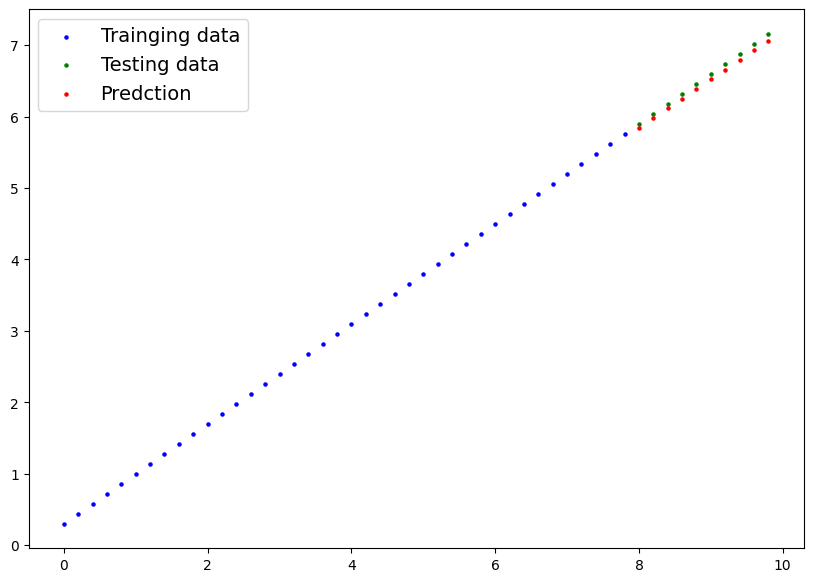

In [233]:
# Load the model up 
# Since the model is stored as a state dict, we have to reconstruct the model to add the statedict into it

load_model = TestingModel()
load_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH)) 
print(load_model.state_dict())

load_model.eval()
with torch.inference_mode(): 
    preds = load_model(X_test)
    plot_predictions(predictions=preds)